In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import binary_f1_score
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device = 'cpu'

In [4]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [5]:
def stratified_under_sample(group: pd.DataFrame, k: int, random_state: int):
    global category_size
    # shuffle data
    group = group.sample(frac=1, random_state=random_state)
    
    # making a dictionary for checking if all the groups are equally insert into the array
    unique_categories = set(group)
    
    # getting the size of each category per fold
    folded_category = category_size // k
    
    # storing temporary data
    test_res = []
    train_res = []

    for i in range(k):
        test_indexes = []
        train_indexes = []
        
        # for each iteration of the outer loop we need to reset dict
        count_type = {category: 0 for category in unique_categories}
        
        for category in unique_categories:
            # making a window of data to retreive
            if (category == 'Background') | (category == 'Benign'):
                start = (folded_category * 2) * i
                stop = (folded_category * 2) * (i + 1)
            else:
                start = folded_category * i
                stop = folded_category * (i + 1)
            test_indexes.extend(group[group == category].iloc[start:stop].index)
        
        for x in group.index:
            if x not in test_indexes:
                train_indexes.append(x)
                
        # shuffling the data with the same seed in order to have the same result in both the dataset
        np.random.shuffle(test_indexes)
        test_res.append(test_indexes)
        np.random.shuffle(train_indexes)
        train_res.append(train_indexes)
        
    return test_res, train_res

In [6]:
# how need to initialize a nn.relu each time you use it
class MLP(nn.Module):
    def __init__(self, n_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(n_features, 6), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(3, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [20]:
def mlp_train(X_train, y_train, verbose, epochs):
    # Initialize the model
    model = MLP(X_train.shape[1]).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if type(X_train) == pd.core.frame.DataFrame:
        X_train = X_train.to_numpy()
    
    # Convert data to PyTorch tensors (assuming X_train and y_train are numpy arrays)
    X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
    y_train_tensor = torch.from_numpy(y_train.to_numpy()).to(device)

  

    # Train the model
    epochs = epochs
    batch_size = 200
    
    start_train = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # Optionally, print the loss at each epoch
        if verbose:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

    end_train = time.time()
    print("execution time: ", end_train - start_train)
        
    return model

In [21]:
def cross_validation(X, y, group, verbose, epochs):
    test_kfold, train_kfold = stratified_under_sample(group, 10, 12)
    '''
    if type(X) == pd.core.frame.DataFrame:
        X = X.to_numpy()
    '''
    cvscores = []

    start_cv = time.time()
    for test, train in zip(test_kfold, train_kfold):
        X_train = scaler.transform(X.loc[train])
        X_test = scaler.transform(X.loc[test])
        
        # rimuovere validation a ogni turno
        model = mlp_train(X_train, y[train], False, epochs)
        
        with torch.no_grad():
            model.eval()
            X_test_tensor = torch.from_numpy(X_test.astype(np.float32)).to(device)
            y_predicted = (model(X_test_tensor) >= 0.5).squeeze().cpu()
            
            cvscores.append(metrics.f1_score(y[test], y_predicted))
    end_cv = time.time()    
    
    return np.mean(cvscores), np.std(cvscores), end_cv - start_cv

In [9]:
with open('mlp_data/ds.pickle', 'rb') as handle:
    ds = pickle.load(handle)

with open('mlp_data/model.pickle', 'rb') as handle:
    model = pickle.load(handle)
    
with open('mlp_data/deep_lift_exp.pickle', 'rb') as handle:
    exp = pickle.load(handle)

In [10]:
category_size = 3279
sampling_weights = {'Background': category_size * 2, 'Benign': category_size * 2, 'XMRIGCC CryptoMiner': category_size, 'Probing': category_size, 'Bruteforce': category_size, 'Bruteforce-XML': category_size}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [11]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

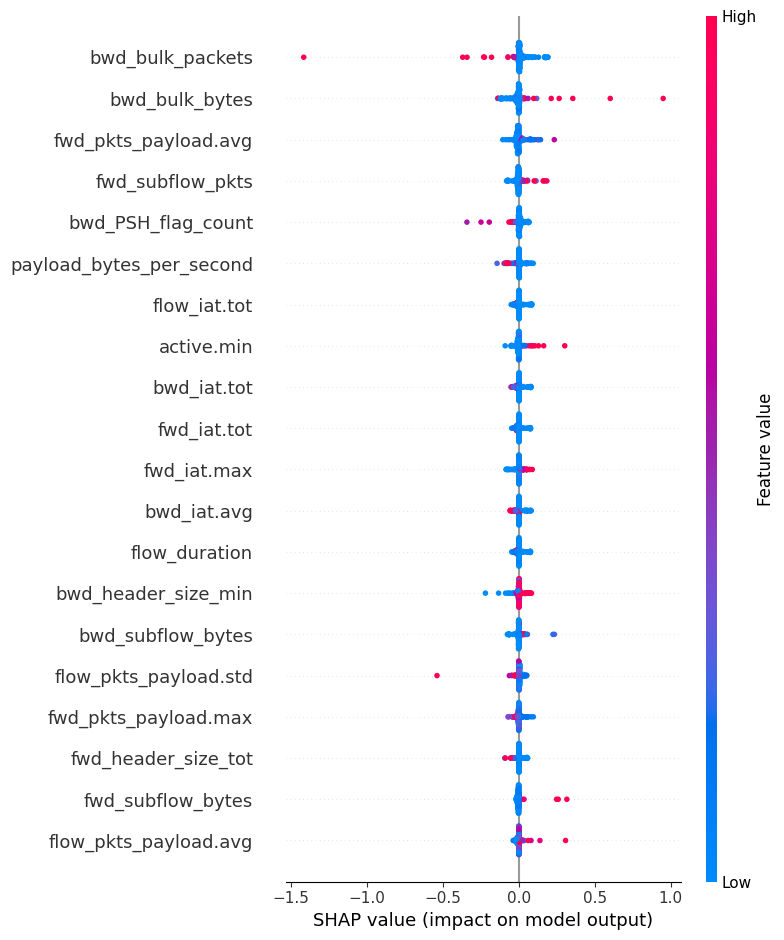

In [12]:
shap.summary_plot(exp, max_display=20)

In [13]:
feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
63,0.031698,bwd_bulk_packets
61,0.029203,bwd_bulk_bytes
28,0.016301,fwd_pkts_payload.avg
56,0.015086,fwd_subflow_pkts
19,0.013526,bwd_PSH_flag_count
55,0.013350,payload_bytes_per_second
52,0.012420,flow_iat.tot
66,0.011912,active.min
47,0.011852,bwd_iat.tot
42,0.011282,fwd_iat.tot


In [14]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [24]:
feature_above_zero = feature_above_zero[:-76]
feature_above_zero

['bwd_bulk_packets', 'bwd_bulk_bytes', 'fwd_pkts_payload.avg']

In [27]:
%%time

# since I'm using only two tree it make sense to split the job on multiple cores
# so each forest will take two cores since it have two tree on it and then I will run along side other 6 forest in order to use all the cores
def get_score(features):
    X = X_res[features]
    y = ds.loc[y_res.index].Label
    cv_mean, cv_std, cv_time = cross_validation(X, y, y_res, 0, 131)
    return cv_mean, cv_std, len(features), cv_time

def recursive_reduction():
    scores = []
    score_std = []
    n_features = []
    cv_time = []

    global scaler
    scaler.fit(ds[['fwd_iat.tot']])

    # making a warm up run otherwise the first one will be always slower than the others
    # only one features so that it can be as fast as possibile
    get_score(['fwd_iat.tot'])

    scaler.fit(ds[feature_above_zero])
    result = get_score(feature_above_zero)
    scores.append(result[0])
    score_std.append(result[1])
    n_features.append(result[2])    
    cv_time.append(result[3])
    
    for i in range(1,len(feature_above_zero)):
        print(f"testing with {len(feature_above_zero[:-i])} features")
        scaler.fit(ds[feature_above_zero[:-i]])
        result = get_score(feature_above_zero[:-i])
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])
        cv_time.append(result[3])
        
    return scores, score_std, n_features, cv_time

result = recursive_reduction()
feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})

execution time:  14.186438798904419
execution time:  14.518194675445557
execution time:  14.938334941864014
execution time:  14.84190559387207
execution time:  14.989662408828735
execution time:  15.209470510482788
execution time:  17.64571762084961
execution time:  17.376767873764038
execution time:  15.377801656723022
execution time:  15.997284412384033
execution time:  15.48797059059143
execution time:  16.379051208496094
execution time:  18.161205053329468
execution time:  17.994620323181152
execution time:  17.35856032371521
execution time:  15.540313720703125
execution time:  15.414971828460693
execution time:  17.05682110786438
execution time:  17.46344256401062
execution time:  18.753684759140015
testing with 2 features
execution time:  16.03272032737732
execution time:  16.320013761520386
execution time:  14.45509386062622
execution time:  14.418349266052246
execution time:  14.161381959915161
execution time:  14.278037786483765
execution time:  14.353712320327759
execution ti

In [62]:
load = True

if load:
    with open('mlp_data/feature_reduction_scores_dl.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)
else:
    with open('mlp_data/feature_reduction_scores_dl.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

<Axes: xlabel='n_features', ylabel='cv_time'>

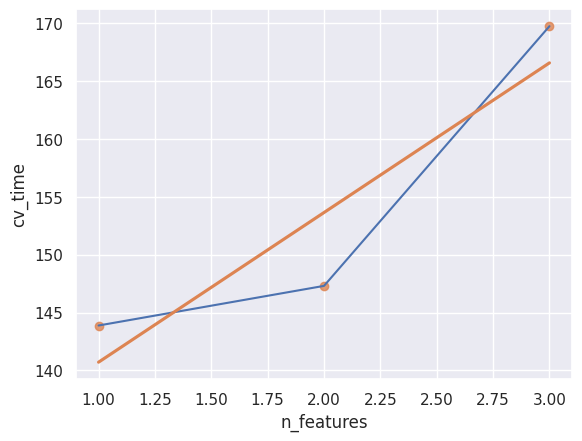

In [28]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

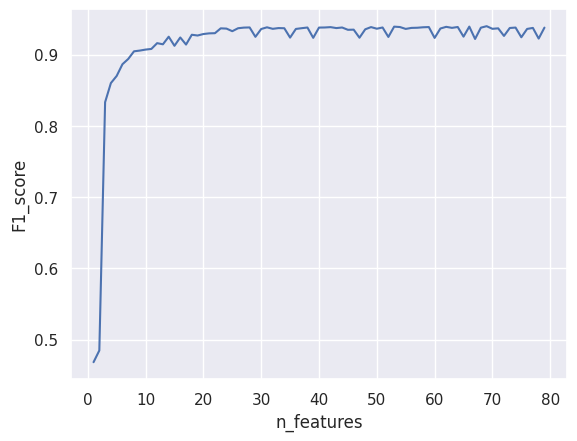

In [55]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

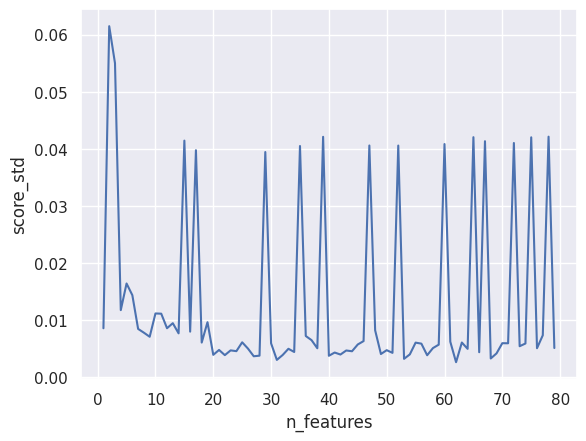

In [56]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [63]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
10,0.940260,0.004206,69,121.703196
13,0.939673,0.004410,66,96.638300
26,0.939610,0.003249,53,210.489051
17,0.939345,0.002664,62,100.409228
15,0.939107,0.005000,64,99.355861
...,...,...,...,...
74,0.870339,0.016448,5,71.753057
75,0.860332,0.011784,4,72.325155
76,0.833497,0.055028,3,73.216638
77,0.484660,0.061520,2,72.309579


In [22]:
# add also training time
attack_f1 = []
attack_recall = []
attack_precision = []
cv_score_avg = []
cv_score_std = []
n_features = []
attacks = []
fit_time = []
pred_time = []

# warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
warmup = True


def test_zero_day(attack, features, rus, rus_attack):
    print(f"training with {len(features)} features")
    global warmup
    epochs = 99
    
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
    X_attack = torch.from_numpy(X_attack.to_numpy().astype(np.float32)).to(device)
    y_attack = ds.loc[y_attack.index].Label
    
    cv_mean, cv_std, cv_time = cross_validation(X_res, ds.loc[y_res.index].Label, y_res, 0, epochs)
    
    if warmup:
        mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
        with torch.no_grad():
            mlp.eval()
            mlp(X_attack)
    
    start_fit = time.time()
    mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
    end_fit = time.time()
    
    with torch.no_grad():
        start_pred = time.time()
        mlp.eval()
        y_predicted = mlp(X_attack)
        end_pred = time.time()
        y_predicted = (y_predicted >= 0.5).squeeze().cpu()
    
    attack_f1.append(metrics.f1_score(y_attack, y_predicted))
    attack_recall.append(metrics.recall_score(y_attack, y_predicted))
    attack_precision.append(metrics.precision_score(y_attack, y_predicted))
    cv_score_avg.append(cv_mean)
    cv_score_std.append(cv_std)
    n_features.append(len(features))
    attacks.append(attack)
    fit_time.append(end_fit - start_fit)
    pred_time.append(end_pred - start_pred)

    # at the very first iteration we change it to false
    warmup = False
    
def recursive_reduction(attack):
    global scaler
    # making a sample for having a 1:1 ration for positive and negative class
    # keep in mind that in the training I will have only three attacks, while for the test only one attack
    sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}
    
    # removing all the attack observations
    sampling_weights[attack] = 0
    
    # doing the undersampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    
    # adding the attack to the test dataset with the non attack traffic
    sampling_attack[attack] = 3279
    
    # making the dataset with only one attack
    rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)
    
    scaler.fit(ds[feature_above_zero])
    test_zero_day(attack, feature_above_zero, rus, rus_attack)

    for i in range(1,len(feature_above_zero)):
        scaler.fit(ds[feature_above_zero[:-i]])
        test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)

for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
    print('traing for ', attack)
    %time recursive_reduction(attack)
    
zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})

traing for  XMRIGCC CryptoMiner
execution time:  7.97981333732605
execution time:  8.058737754821777
execution time:  8.013308048248291
execution time:  8.330711126327515
execution time:  7.920430898666382
execution time:  8.232296705245972
execution time:  8.058387517929077
execution time:  8.60338044166565
execution time:  9.139482498168945
execution time:  9.02397894859314
execution time:  9.52441120147705
execution time:  9.215676069259644
CPU times: user 6min 54s, sys: 1.24 s, total: 6min 55s
Wall time: 1min 49s
traing for  Probing
execution time:  8.229112148284912
execution time:  8.321290016174316
execution time:  8.076944589614868
execution time:  8.318347930908203
execution time:  8.023653268814087
execution time:  8.276994228363037
execution time:  8.090268850326538
execution time:  8.61668872833252
execution time:  9.05104112625122
execution time:  9.310497760772705
execution time:  9.658327579498291
CPU times: user 6min 21s, sys: 1.04 s, total: 6min 22s
Wall time: 1min 40s

In [31]:
with open('mlp_data/zero_day_feature_reduction_scores_dl.pickle', 'wb') as handle:
    pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)